In [146]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt, seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

import librosa, librosa.display
import IPython.display as ipd

plt.rcParams['figure.figsize'] = (10, 3)

# Classification with given features

## Data split (train/test)

In [147]:
features_30_sec = pd.read_csv('data/GTZAN_data/features_30_sec.csv')
features_3_sec = pd.read_csv('data/GTZAN_data/features_3_sec.csv')

data_each_song = features_30_sec

Split songs to train and test with 30 seconds data

In [148]:
X = data_each_song.drop(columns=['label'])
labels = data_each_song.loc[:,'label']
cat_y = pd.Categorical(labels)
y = pd.Series(cat_y.codes)

In [149]:
# train / test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=123)

In [150]:
# songs to train
fn_train = np.sort(X_train.filename.values)

# songs to test
fn_test = np.sort(X_test.filename.values)

Apply the split to  3 seconds data

In [151]:
data = features_3_sec

In [152]:
songs = []
for i in range(len(data)):
    split = data.filename[i].split('.')
    songs.append(split[0]+'.'+split[1]+'.'+split[3])
data['songname'] = pd.Series(songs)

In [153]:
song_data_ = []
for song in fn_train:
    song_data_.append(data[data.songname==song])
train_data = pd.concat(song_data_)

song_data_ = []
for song in fn_test:
    song_data_.append(data[data.songname==song])
test_data = pd.concat(song_data_)

In [154]:
X_train = train_data.iloc[:,1:-2]
y_train = pd.Series(pd.Categorical(train_data.loc[:,'label']).codes)

X_test = test_data.iloc[:,1:-2]
y_test = pd.Series(pd.Categorical(test_data.loc[:,'label']).codes)

In [155]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [156]:
y_train.value_counts()

5    780
4    779
6    740
0    730
1    719
7    680
8    670
2    659
9    620
3    619
dtype: int64

In [157]:
y_test.value_counts()

3    380
9    378
2    338
8    330
7    320
1    279
0    270
6    260
5    220
4    219
dtype: int64

## Model

In [158]:
svc = SVC(kernel='rbf')
rf = RandomForestClassifier()
# clf = AdaBoostClassifier()
# clf = GradientBoostingClassifier()
xgb = XGBClassifier(n_estimators=100)

**Hyperparameter tuning**

In [159]:
param_grid1 = {'C': [10, 100], 
              'gamma': [0.1, 0.01, 0.001]} 
cv = StratifiedKFold(n_splits=3, shuffle=True)  
grid1 = GridSearchCV(svc, param_grid1, cv=cv, verbose = 1)
grid1.fit(X_train_scaled, y_train)
print(grid1.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
SVC(C=100, gamma=0.01)


In [160]:
param_grid2 = {'n_estimators': [50, 100],
               'max_depth': [None, 6, 12]}
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid2 = GridSearchCV(rf, param_grid2, cv=cv, verbose = 1)
grid2.fit(X_train, y_train)
print(grid2.best_estimator_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
RandomForestClassifier()


In [162]:
param_grid3 = {'learning_rate': [0.01, 0.1, 0.3, 0.5]}
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid3 = GridSearchCV(xgb, param_grid3, cv=cv, verbose = 1)
grid3.fit(X_train, y_train)
print(grid3.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)


**train**

In [164]:
clf1 = grid1.best_estimator_
clf1.fit(X_train_scaled, y_train)

clf2 = grid2.best_estimator_
clf2.fit(X_train, y_train)

clf3 = grid3.best_estimator_
clf3.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

**predict**

In [165]:
# for SVC
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [166]:
y_true = y_test.copy()
y_pred1 = clf1.predict(X_test_scaled) # SVC
y_pred2 = clf2.predict(X_test)
y_pred3 = clf3.predict(X_test)

## Results

SVM Accuracy:  0.6850367401469606
SVM F1:  0.6918251091907079


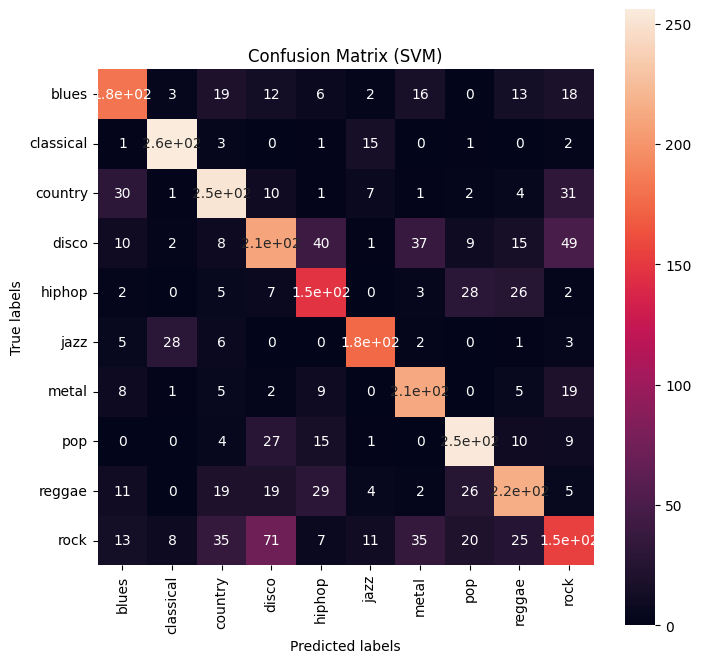

In [167]:
print('SVM Accuracy: ', accuracy_score(y_true, y_pred1))
print('SVM F1: ', f1_score(y_true, y_pred1, average='macro'))

f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true, y_pred1), annot=True, square=True, 
            xticklabels=cat_y.categories, yticklabels=cat_y.categories, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (SVM)')
plt.show()

In [168]:
print("SVC classification report:",'\n')
print(classification_report(y_true, y_pred1))
print(dict(zip(cat_y.categories, range(10))))

SVC classification report: 

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       270
           1       0.86      0.92      0.89       279
           2       0.71      0.74      0.72       338
           3       0.59      0.55      0.57       380
           4       0.57      0.67      0.62       219
           5       0.81      0.80      0.80       220
           6       0.69      0.81      0.74       260
           7       0.75      0.79      0.77       320
           8       0.68      0.65      0.67       330
           9       0.53      0.40      0.46       378

    accuracy                           0.69      2994
   macro avg       0.69      0.70      0.69      2994
weighted avg       0.68      0.69      0.68      2994

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


RF Accuracy:  0.6826987307949232
RF F1:  0.6855767167941398


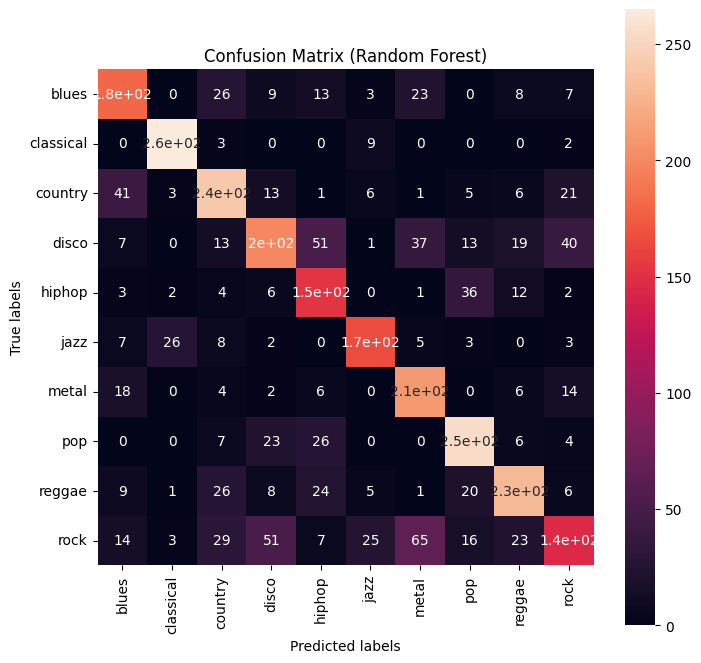

In [169]:
print('RF Accuracy: ', accuracy_score(y_true, y_pred2))
print('RF F1: ', f1_score(y_true, y_pred2, average='macro'))

f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true, y_pred2), annot=True, square=True, 
            xticklabels=cat_y.categories, yticklabels=cat_y.categories, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (Random Forest)')
plt.show()

In [170]:
print("RF classification report:",'\n')
print(classification_report(y_true, y_pred2))
print(dict(zip(cat_y.categories, range(10))))

RF classification report: 

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       270
           1       0.88      0.95      0.92       279
           2       0.67      0.71      0.69       338
           3       0.64      0.52      0.57       380
           4       0.54      0.70      0.61       219
           5       0.77      0.75      0.76       220
           6       0.61      0.81      0.70       260
           7       0.73      0.79      0.76       320
           8       0.74      0.70      0.72       330
           9       0.59      0.38      0.47       378

    accuracy                           0.68      2994
   macro avg       0.68      0.70      0.69      2994
weighted avg       0.68      0.68      0.68      2994

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


XGB Accuracy:  0.7077488309953239
XGB F1:  0.7136242718729457


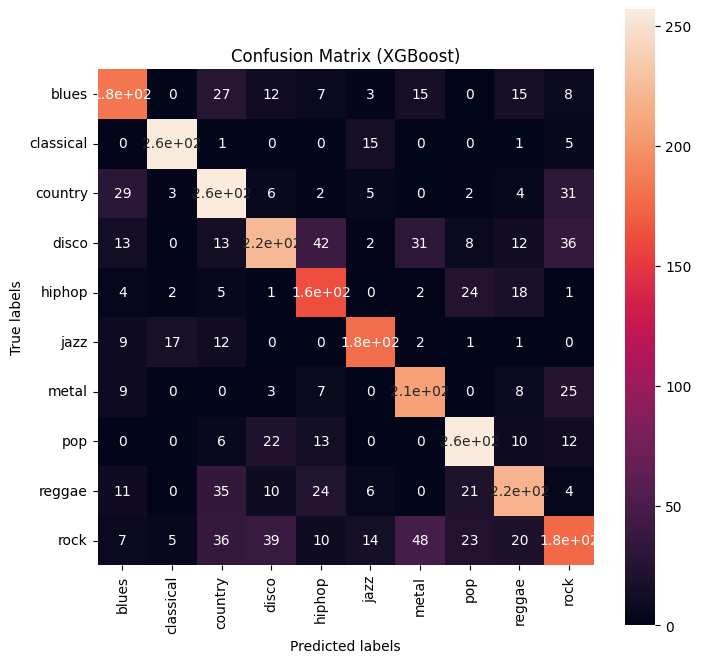

In [171]:
print('XGB Accuracy: ', accuracy_score(y_true, y_pred3))
print('XGB F1: ', f1_score(y_true, y_pred3, average='macro'))

f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true, y_pred3), annot=True, square=True, 
            xticklabels=cat_y.categories, yticklabels=cat_y.categories, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (XGBoost)')
plt.show()

In [172]:
print("XGB classification report:",'\n')
print(classification_report(y_true, y_pred3))
print(dict(zip(cat_y.categories, range(10))))

XGB classification report: 

              precision    recall  f1-score   support

           0       0.69      0.68      0.68       270
           1       0.90      0.92      0.91       279
           2       0.65      0.76      0.70       338
           3       0.71      0.59      0.64       380
           4       0.61      0.74      0.67       219
           5       0.80      0.81      0.80       220
           6       0.68      0.80      0.73       260
           7       0.76      0.80      0.78       320
           8       0.71      0.66      0.69       330
           9       0.59      0.47      0.52       378

    accuracy                           0.71      2994
   macro avg       0.71      0.72      0.71      2994
weighted avg       0.71      0.71      0.70      2994

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


## interpretation

- As a result of checking the performance of the classifier by targeting the genre for 3 seconds(1/10 part) of each song, it can be seen that the accuracy and F1 score are about 69%. XGboost shows highest performace scores among the models

- As you can see in the confusion matrix some specific genres are misclassified. Let's check this case by case.

- First of all, let's look at which genre was most mis-predicted for each genre. (RF based)
     - **Blues**: Country 31, Metal 23, etc.
     - **Classical** (high score - well classified): Jazz 12
     - **Country**: Blues 35, Rock 18, etc.
     - **Disco**: Hip Hop 55, Metal 31, Rock 31, etc.
     - **Hip Hop**: Pop 32, Reggae 19
     - **Jazz**: Classic 23
     - **Metal**: Blues 17, Rock 14, etc.
     - **Pop**: Hip Hop 30, Disco 17, etc.
     - **Reggae**: Country 24, Hip Hop 23, etc.
     - **Rock** (low score): Metal 69, Disco 4, etc.
    
- Looking at the misclassified genres, we can see the pairs: **blues-country, classical-jazz, disco-hip-hop, pop-hip-hop, hip-hop-reggae, metal-rock**. Intuitively, it is mainly genre pairs that are generally thought to have genre similarities (but there are some pairs that are not; **metal-blues, raggae-country**; maybe they have some similar musical characteristics)

- In other words, it can be inferred that the feature based on the given audio content has some musical characteristic information, similar to the genre artificially classified by people.

## feature importance

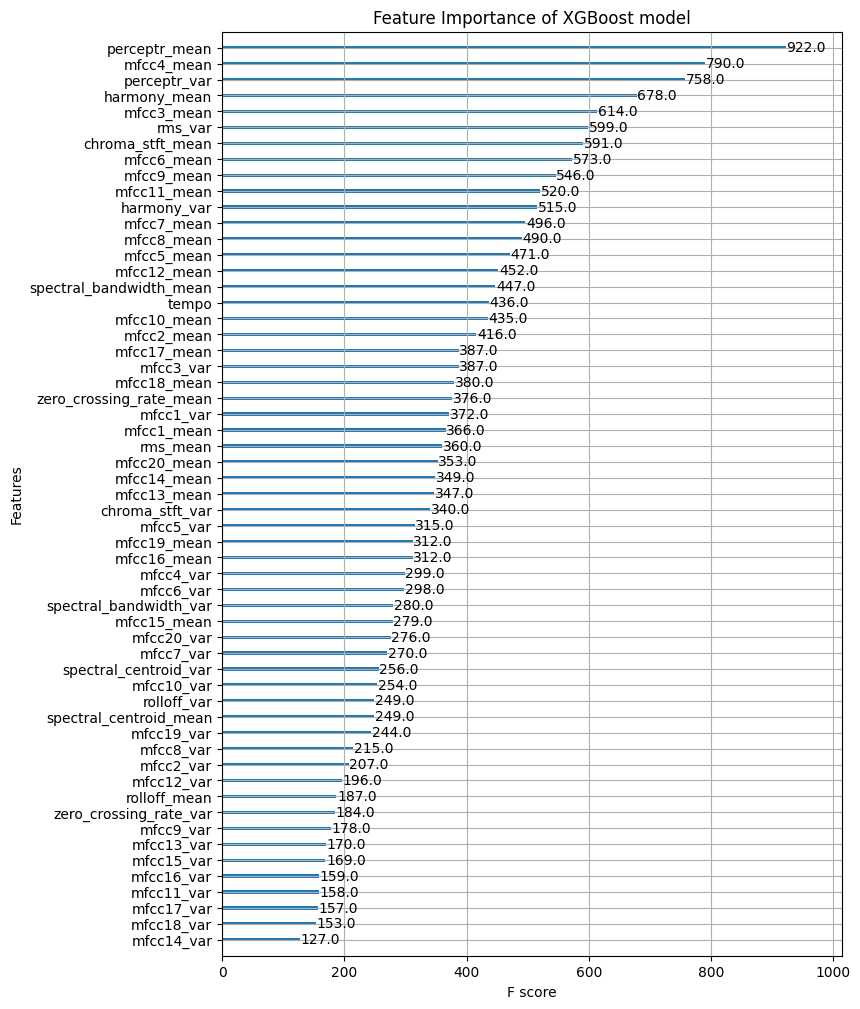

In [173]:
fig, ax = plt.subplots(figsize=(8,12))
from xgboost import plot_importance
plot_importance(clf3, ax=ax, title='Feature Importance of XGBoost model')
plt.show()

- hamornic, percussive time series features have high importance.
- spectral features have relatively low importance.
- mfcc features variance have very low importance.

## without variance features

- excluding variances
- for simplicity only using xgboost with default parameters

In [174]:
feat_names = [col for col in train_data.columns if 'mean' in col] # only mean data

In [175]:
X_train = train_data.loc[:,feat_names]
y_train = pd.Series(pd.Categorical(train_data.loc[:,'label']).codes)

X_test = test_data.loc[:,feat_names]
y_test = pd.Series(pd.Categorical(test_data.loc[:,'label']).codes)

In [176]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.5)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [177]:
y_true = y_test.copy()
y_pred4 = xgb.predict(X_test)

XGB Accuracy:  0.6539746158984636
XGB F1:  0.659085001926225


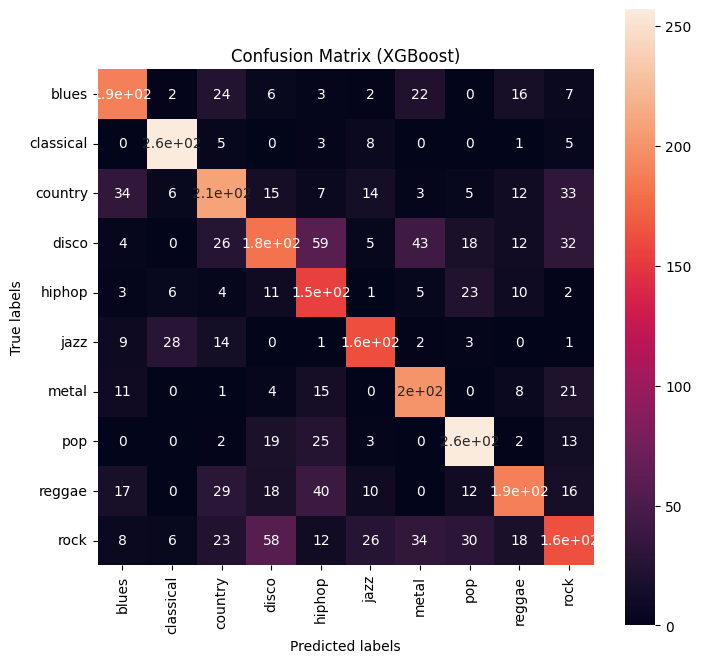

In [178]:
print('XGB Accuracy: ', accuracy_score(y_true, y_pred4))
print('XGB F1: ', f1_score(y_true, y_pred4, average='macro'))

f,ax= plt.subplots(figsize=(8,8))
sns.heatmap(confusion_matrix(y_true, y_pred4), annot=True, square=True, 
            xticklabels=cat_y.categories, yticklabels=cat_y.categories, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix (XGBoost)')
plt.show()

- lower scores but not that bad

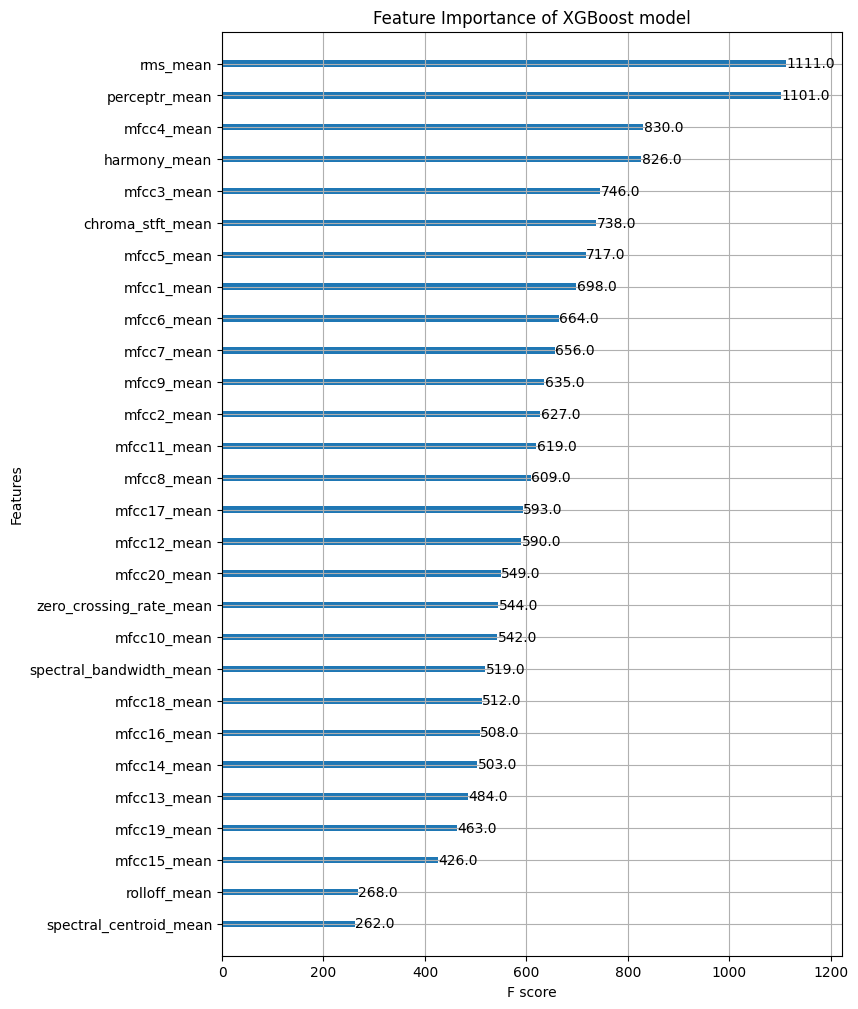

In [179]:
fig, ax = plt.subplots(figsize=(8,12))
plot_importance(xgb, ax=ax, title='Feature Importance of XGBoost model')
plt.show()